# Poços correlatos
## Abstrato
 Os poços correlatos são poços que compartem algumas características em comum. 
 O objetivo de este notebook é encontrar as correlações entre poços. Para ese objetivo
 usaremos os métodos de clustering (agrupação) disponiveis nas livrarias de scikit learn.
 Por fim, usaremos o modelo de clustering para caracterizar um pozo particular
 e definir a qual agrupação pertenece. 

In [1]:
# Imports

import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline


In [91]:
# Versões dos pacotes usados no notebook

%reload_ext watermark
%watermark -a "César S. Hooper/ Setembro 2022" --iversions
!python --version

Author: César S. Hooper/ Setembro 2022

numpy     : 1.19.5
pandas    : 1.2.4
matplotlib: 3.3.4
seaborn   : 0.11.1

Python 3.8.8


## Leitura e limpeza dos dados

Começamos criando um dataframe com os dados de prova.

In [144]:
# DF com os dados de prova
dprova = {'nome': ['2JAUCG', '2JAUCG', '2JAUCG', '2JAUCG'],
         'fase': [1, 2, 3, 4],
         'hole_type': ['VERTICAL', 'VERTICAL', 'VERTICAL', 'VERTICAL'],
         'lda': [598.0, 598.0, 598.0, 598.0],
         'fase_diameter': [26, 17.5, 12.25, 8.5],
          'metragen': [607.0, 1306.0, 1201.0, 1445.0],
          'n_fase': [1, 2, 3, 4]
         }
dprova = pd.DataFrame(dprova)
dprova

,nome,fase,hole_type,lda,fase_diameter,metragen,n_fase
0,2JAUCG,1,VERTICAL,598.0,26.00,607.0,1
1,2JAUCG,2,VERTICAL,598.0,17.50,1306.0,2
2,2JAUCG,3,VERTICAL,598.0,12.25,1201.0,3
3,2JAUCG,4,VERTICAL,598.0,8.50,1445.0,4


In [145]:
# leitura dos dados dos poços
path = 'C:/Users/Cesar Hooper/Desktop/github/proyecto_POZO'
dataset = pd.read_csv(path + '/dados_pocos.csv')

# trocamos o nome das colunas
columnas = ['unnamed', 'name', 'fase', 'hole_type', 'lda', 'fase_diameter', 'metragen', 'n_fase'];
dataset.columns = columnas
dataset.head()

,unnamed,name,fase,hole_type,lda,fase_diameter,metragen,n_fase
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3


In [95]:
# Info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10649 entries, 0 to 10648
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   unnamed        10649 non-null  int64  
 1   name           10649 non-null  object 
 2   fase           10649 non-null  int64  
 3   hole_type      10649 non-null  object 
 4   lda            10649 non-null  float64
 5   fase_diameter  10649 non-null  object 
 6   metragen       10649 non-null  float64
 7   n_fase         10649 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 665.7+ KB


Temos variaveis categóricas, variaveis numéricas e strings. A coluna fase_diameter é um string que contem os diámetros das perfurações em polegadas; são valores pequenos se compararmos com LDA e Metragen, considerando que 1 polegada = 2.54 cm. Então o modelo poderia resultar insensitivo a os valores do fase_diameter pelos rangos de magnitude das outras variaveis (alguns poucos cm vs centenares de metros). 

Então, vamos fazer dois procedimentos: 
   * Transformar a coluna fase_diameter para formato numérico decimal
   * Normalizar as colunas **fase_diameter, metragen e LDA**, restando a media e dividindo pela desviação.

Usaremos dois funções que estão no Apendix no final desse notebook. 

In [97]:
# Usamos função trans_diam e agregamos a nova coluna noDF
dataset['diametros'] = trans_diam(dataset['fase_diameter'])

# usamos função normalizacion e agregamos as novas colunas no DF
dataset['diam_norm'] = normalizacion(dataset['diametros'])
dataset['lda_norm'] = normalizacion(dataset['lda'])
dataset['metragen_norm'] = normalizacion(dataset['metragen'])

dataset.head()

,unnamed,name,fase,hole_type,lda,fase_diameter,metragen,n_fase,diametros,diam_norm,lda_norm,metragen_norm
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4,26.00,1.068702,-0.692318,-0.125920
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4,17.50,0.076953,-0.692318,1.113005
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4,12.25,-0.535597,-0.692318,0.926900
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4,8.50,-0.973133,-0.692318,1.359372
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3,17.50,0.076953,-1.507541,-0.475088


## Análise dos dados

Para começar com o análise, vamos tentar encontrar padrões que indiquem a existência e quantidade de clusters de dados. 

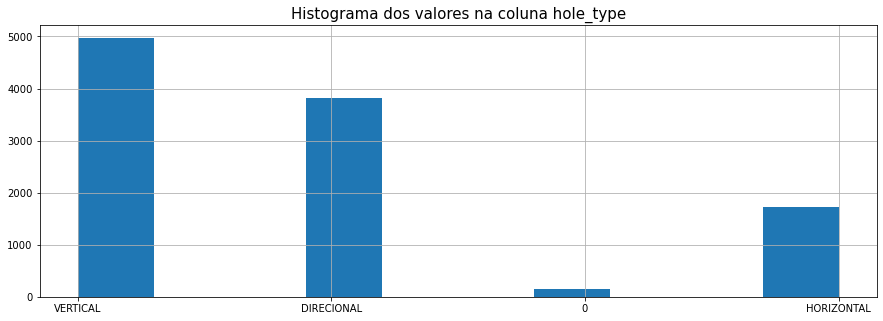

In [118]:
# histograma das quantidades de vada valor na coluna hole_type
plt.figure(figsize=(15, 5))
dataset['hole_type'].hist()
plt.title('Histograma dos valores na coluna hole_type', fontsize=15)
plt.show()

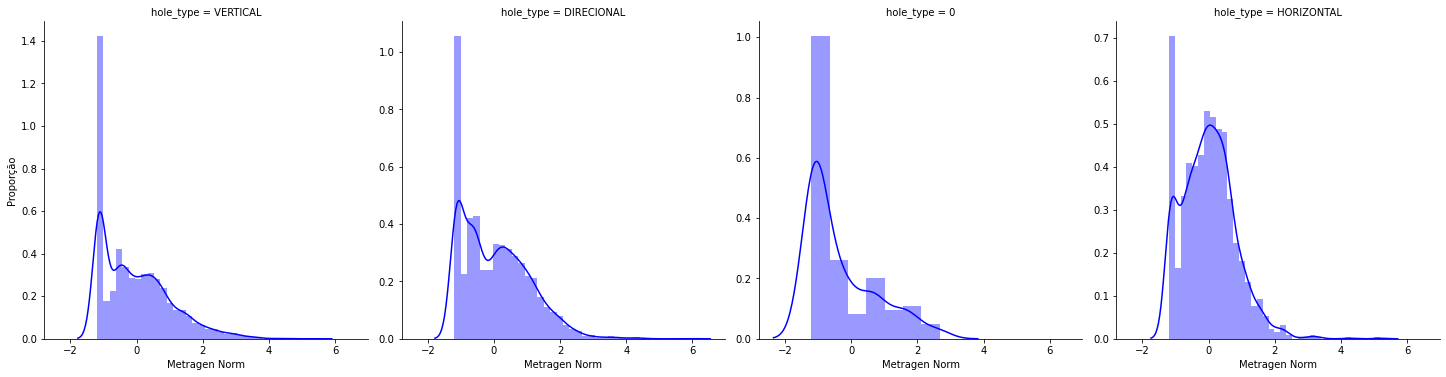

In [123]:
# distribução dos valores do metragen normalizado segundo o tipo de perfuração
grafico = sns.FacetGrid(dataset, col='hole_type', height=5, sharey = False, sharex = True)
grafico.map(sns.distplot, 'metragen_norm', color='b')
grafico.set_axis_labels('Metragen Norm', 'Proporção')
grafico.fig.subplots_adjust(top=1)
plt.show()

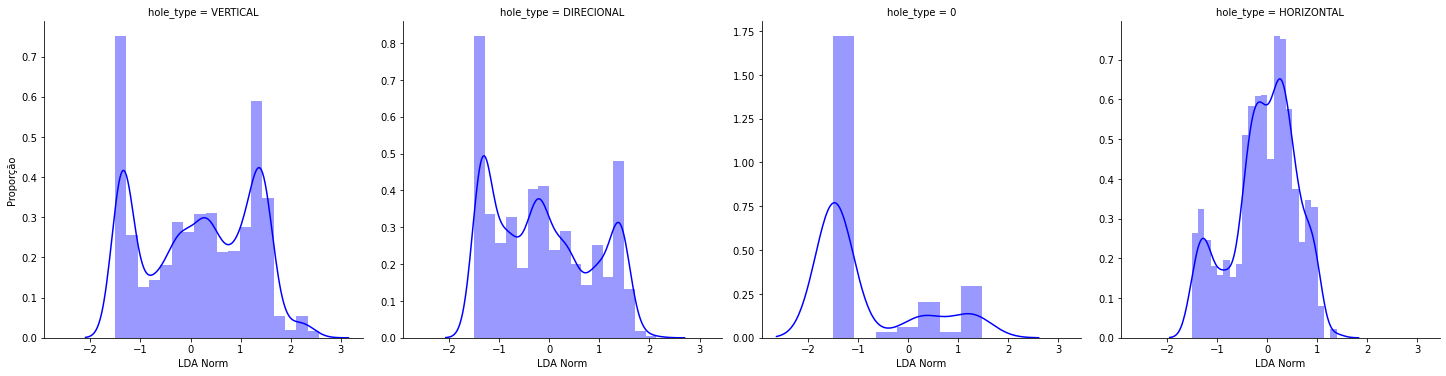

In [127]:
grafico = sns.FacetGrid(dataset, col='hole_type', height=5, sharey = False, sharex = True)
grafico.map(sns.distplot, 'lda_norm', color='b')
grafico.set_axis_labels('LDA Norm', 'Proporção')
grafico.fig.subplots_adjust(top=1)
plt.show()

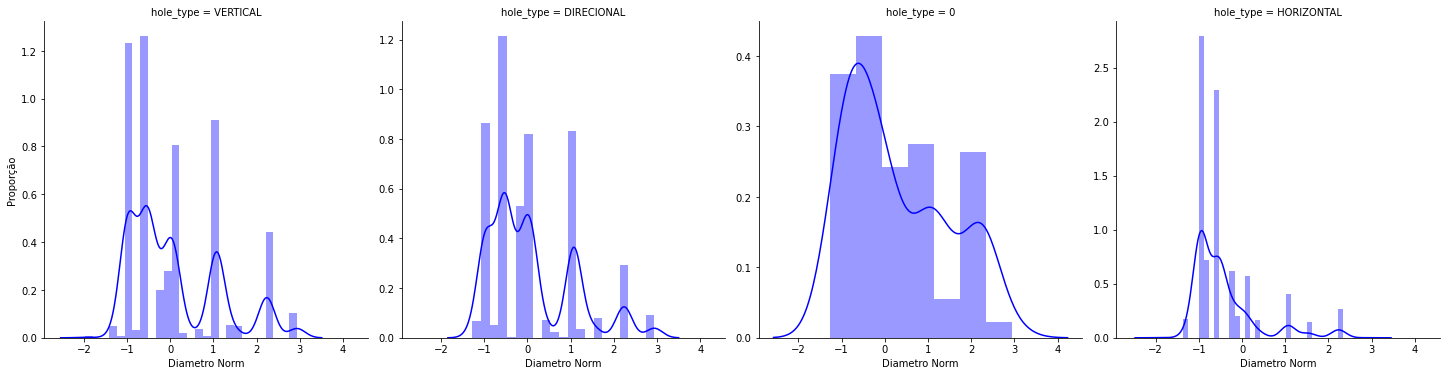

In [126]:
grafico = sns.FacetGrid(dataset, col='hole_type', height=5, sharey = False, sharex = True)
grafico.map(sns.distplot, 'diam_norm', color='b')
grafico.set_axis_labels('Diametro Norm', 'Proporção')
grafico.fig.subplots_adjust(top=1)
plt.show()

Vamos separar os dados com perfuração **VERTICAL** dos outros, e estudar os posiveis clusters gerados dentro de um grupo menor de dados, e com fase entre os valores 1 e 4, em correspondência com os dados de prova (dprova) 

In [135]:
dados_vert = dataset[dataset['hole_type'] =='VERTICAL']
dados_vf4 = dados_vert[dados_vert['fase']<5]
dados_vf4.head()

,unnamed,name,fase,hole_type,lda,fase_diameter,metragen,n_fase,diametros,diam_norm,lda_norm,metragen_norm
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4,26.00,1.068702,-0.692318,-0.125920
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4,17.50,0.076953,-0.692318,1.113005
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4,12.25,-0.535597,-0.692318,0.926900
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4,8.50,-0.973133,-0.692318,1.359372
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3,17.50,0.076953,-1.507541,-0.475088


<Figure size 1800x1800 with 0 Axes>

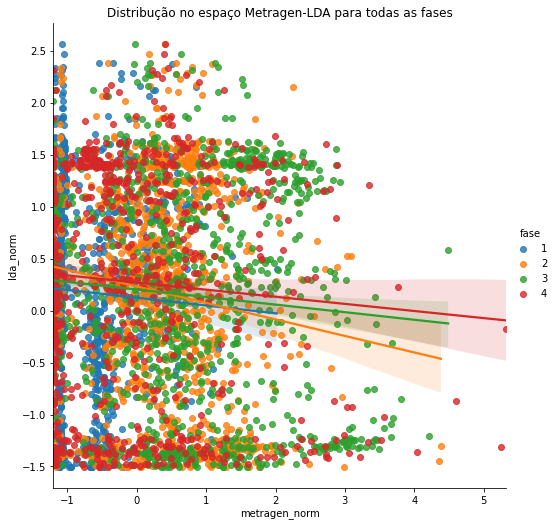

In [147]:
plt.figure(figsize=(25,25))
sns.lmplot(x = "metragen_norm", y = "lda_norm", hue = "fase", data = dados_vf4, height = 7)
plt.title('Distribução no espaço Metragen-LDA para todas as fases')
plt.show()

<Figure size 1800x1800 with 0 Axes>

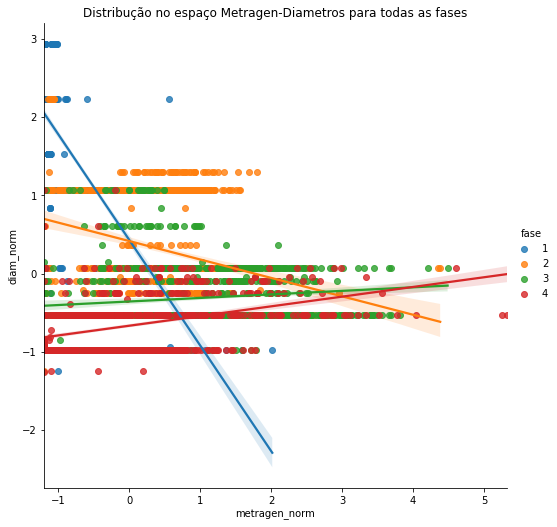

In [148]:
plt.figure(figsize=(25,25))
sns.lmplot(x = "metragen_norm", y = "diam_norm", hue = "fase", data = dados_vf4, height = 7)
plt.title('Distribução no espaço Metragen-Diametros para todas as fases')
plt.show()

<Figure size 1080x360 with 0 Axes>

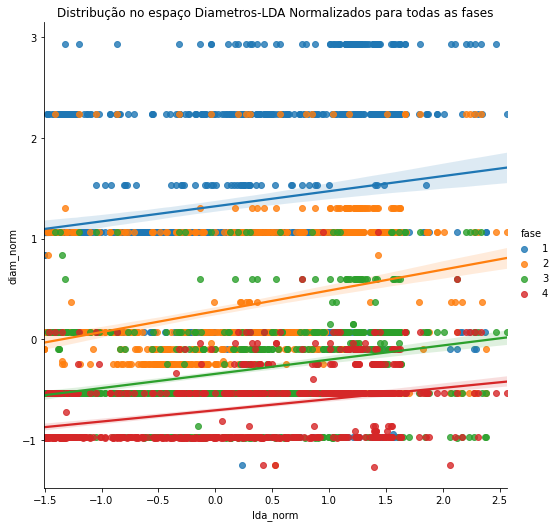

In [185]:
plt.figure(figsize=(15,5))
sns.lmplot(x = "lda_norm", y = "diam_norm", hue = "fase", data = dados_vf4, height = 7)
plt.title('Distribução no espaço Diametros-LDA Normalizados para todas as fases')
plt.show()

Os pontos estão evidentemente misturados, mas é posivel intuir patrões de formação de cúmulos. Mas, para ter maior certeza vamos a usar o método de saturação Inertia.

## Inertia

O intertia calcula a suma da distância ao cuadrado de cada ponto dos dados con os centros de cada cluster. 
Importamos o modelo de clustering KMeans.

O números de clusters se determina quando a curva começa a decaer linearmente, ou seja, com inclinação constante. 

In [187]:
# importa o modelo KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [159]:
dados_vf4.head()

,unnamed,name,fase,hole_type,lda,fase_diameter,metragen,n_fase,diametros,diam_norm,lda_norm,metragen_norm
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4,26.00,1.068702,-0.692318,-0.125920
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4,17.50,0.076953,-0.692318,1.113005
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4,12.25,-0.535597,-0.692318,0.926900
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4,8.50,-0.973133,-0.692318,1.359372
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3,17.50,0.076953,-1.507541,-0.475088


In [160]:
# Separamos as colunas de interesse
X = dados_vf4[['fase', 'hole_type', 'lda_norm', 'diam_norm', 'metragen_norm']].copy()
X['hole_type'] = 1
X.head()

,fase,hole_type,lda_norm,diam_norm,metragen_norm
0,1,1,-0.692318,1.068702,-0.125920
1,2,1,-0.692318,0.076953,1.113005
2,3,1,-0.692318,-0.535597,0.926900
3,4,1,-0.692318,-0.973133,1.359372
4,1,1,-1.507541,0.076953,-0.475088


In [192]:
# train, test and validation data
X_train, X_test = train_test_split(X, test_size=0.4)

# inertia
inertia_list = []
silhouette_list = []
for num_clusters in range(2, 15):
    kmeans= KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans.fit(X_train)
    inertia_list.append(kmeans.inertia_)
    
    # silhouette 
    cluster_labels = kmeans.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_list.append(silhouette_avg)

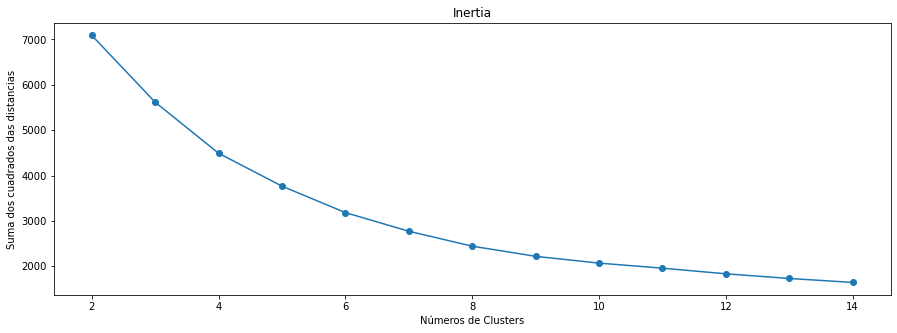

In [194]:
# plots
plt.figure(figsize=(15,5))
plt.plot(range(2,15),inertia_list)
plt.scatter(range(2,15),inertia_list)
plt.xlabel('Números de Clusters')
plt.ylabel('Suma dos cuadrados das distancias')
plt.title('Inertia')
plt.show()

In [195]:
# calcuamos a percentual de variação da inclinação da curva para cada cluster
m = []
for k in range(0, len(inertia_list)-1):
    m.append((inertia_list[k+1] - inertia_list[k])/inertia_list[k])

100*np.abs(m)

array([20.7772525 , 20.0358668 , 16.1559366 , 15.47527808, 12.91323706,
       11.86857942,  9.17868525,  6.73868105,  5.37401413,  6.33524882,
        5.60066536,  5.08251737])

In [196]:
inertia = pd.DataFrame({'N_clusters':[3, 4, 5, 6, 7,8,9, 10, 11, 12, 13, 14],
                        'm_%': 100*np.abs(m)})
inertia

,N_clusters,m_%
0,3,20.777253
1,4,20.035867
2,5,16.155937
3,6,15.475278
4,7,12.913237
5,8,11.868579
6,9,9.178685
7,10,6.738681
8,11,5.374014
9,12,6.335249


Para uma tolerancia menor do 15% o número de cluster 6. Mas, com uma tolerancia perto do 10% o número de clusters é 8.
Então, vamos usar esse número de cluster na construção do nosso modelo.

Por outro lado, usaremos também o Silhouette score para nos ajudar encontrar o melhor número de clusters

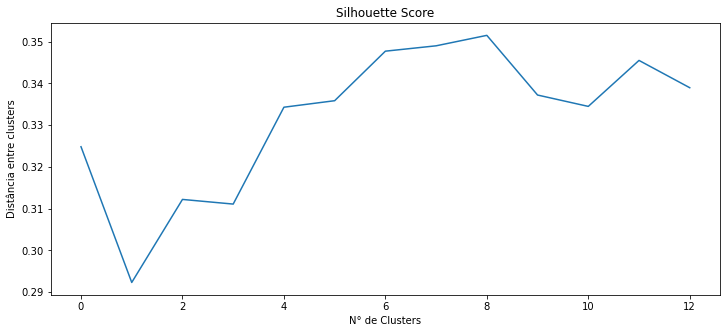

In [204]:
plt.figure(figsize=(12,5))
plt.plot(silhouette_list)
plt.xlabel('N° de Clusters')
plt.ylabel('Distância entre clusters')
plt.title('Silhouette Score')
plt.show()

Podemos observar que o maior score se produce com 8 clusters. 

Deixamos o modelo com Número de clusters 8.

## Modelo aplicado aos dados de treino e teste

Vamos usar o modelo KMeans com N_clusters=8.
Vamos aplicar esse modelo sobre nossos dados de teste. Logo, aplicaremos o modelo sobre os dados de prova. 

In [212]:
# Modelo KMeans con N_cluster = 8
N = 8
kmean = KMeans(n_clusters=N, init="k-means++")
kmean.fit(X_train)
y_pred_test = kmean.predict(X_test)
y_pred_train = kmean.predict(X_train)

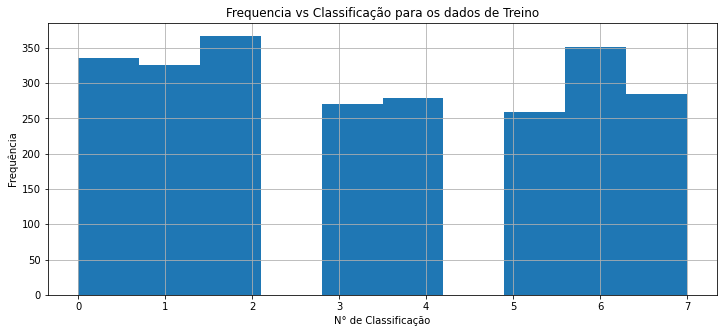

In [227]:
# distribuição das categorias criadas para os dados treino
plt.figure(figsize=(12,5))
pd.Series(y_pred_train).hist()
plt.xlabel('N° de Classificação')
plt.ylabel('Frequência')
plt.title('Frequencia vs Classificação para os dados de Treino')
plt.show()

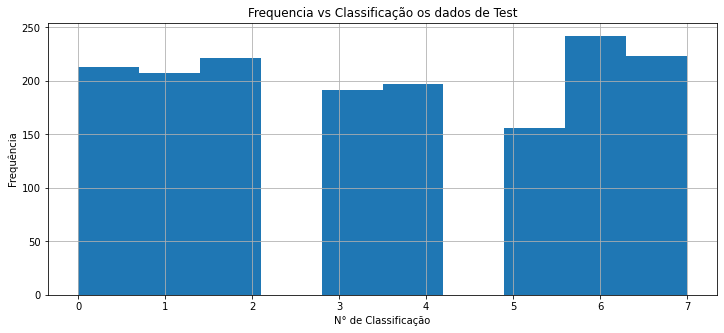

In [228]:
# distribuição das categorias criadas para os dados test
plt.figure(figsize=(12,5))
pd.Series(y_pred_test).hist()
plt.xlabel('N° de Classificação')
plt.ylabel('Frequência')
plt.title('Frequencia vs Classificação os dados de Test')
plt.show()

Aparentemente o modelo não tem preferências na hora de fazer clasificação

## Aplicação do Modelo sobre os dados de prova

In [215]:
dprova

,nome,fase,hole_type,lda,fase_diameter,metragen,n_fase
0,2JAUCG,1,VERTICAL,598.0,26.00,607.0,1
1,2JAUCG,2,VERTICAL,598.0,17.50,1306.0,2
2,2JAUCG,3,VERTICAL,598.0,12.25,1201.0,3
3,2JAUCG,4,VERTICAL,598.0,8.50,1445.0,4


In [229]:
# devemos deixar os dados no formato adecuado
dprova['lda_norm'] = 1
dprova['diam_norm'] = normalizacion(dprova['fase_diameter'])
dprova['metragen_norm'] = normalizacion(dprova['metragen'])
Y = dprova[['fase', 'hole_type', 'lda_norm', 'diam_norm', 'metragen_norm']].copy()
Y['hole_type'] = 1
Y

,fase,hole_type,lda_norm,diam_norm,metragen_norm
0,1,1,1,1.310341,-1.443930
1,2,1,1,0.189546,0.450593
2,3,1,1,-0.502709,0.166008
3,4,1,1,-0.997177,0.827329


Aplicamos o modelo aos dados de prova

In [230]:
y_pred_prova = kmean.predict(Y)

In [231]:
y_pred_prova

array([7, 5, 0, 3])

## Conclusão
Os dados de prova estão classificados nas categorias 7, 5, 0, 3

## Apendix

In [8]:
def trans_diam(diametros):
    '''função para transformar strings em float da coluna diameter'''
    values = [];
    
    for diam in diametros:
        diam = diam.split();
        if (len(diam)==2):
            p = diam[1].split('/');
            diametro = int(diam[0]) + int(p[0])/int(p[1])
        else: diametro = int(diam[0])
            
        values.append(diametro)
    return pd.Series(values, index=diametros.index)

In [36]:
def normalizacion(datos):
    
    media = datos.mean()
    estandar = datos.std()
    norm = (datos - media)/estandar
    return norm